##### Projet CO2 par Polina, Vincent, Denis

Ce notebook:
entraine un modèle de classification pour prédiction par Gradient Boosting Machines Catboost  
Prend en entrée les fichiers:
    (processed)/X_test_scaled.csv, X_train_scaled.csv, y_test_cat.csv, y_train_cat.csv : les données scalées et donc forcément préalablement séparées en jeux de train/test.

Fournit en sortie les fichiers:
    (models)/<nom_de_modele>.pkl


In [21]:
# Pour une exécution indépendante des travaux sur chaque modèle: Charger les données depuis les fichiers CSV

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
pd.set_option('future.no_silent_downcasting', True)
              
def load_our_data_cat():
    # charge les chemins vers les fichiers de données : base_processed, base_raw, base_models...
    %run init_notebook.py

    X_train_scaled = pd.read_csv(base_processed + 'X_train_scaled.csv')
    X_test_scaled = pd.read_csv(base_processed + 'X_test_scaled.csv')
    y_train = pd.read_csv(base_processed + 'y_train_cat.csv')
    y_test = pd.read_csv(base_processed + 'y_test_cat.csv')
    X_train_scaled = X_train_scaled.replace({False: 0, True: 1}).astype(float)
    X_test_scaled = X_test_scaled.replace({False: 0, True: 1}).astype(float)
    #
    y_column = "categorie"
    y_train = y_train[y_column]
    y_test = y_test[y_column]
    return X_train_scaled, X_test_scaled, y_train, y_test


# Classification par Gradient Boosting Machines Catboost

In [22]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "16"  # nombre de cœurs physiques réels


In [23]:
X_train_scaled, X_test_scaled, y_train, y_test=load_our_data_cat()

In [24]:
# Cette case est une référence pour les hyperparamètres du modèle


n_estimators = 100

max_features= 'sqrt' # nombre de caractéristiques à considérer pour chaque split. dqrt=racine du nbre de caracs
# max_features= 'log2' # est une alternative. Ou bien un nombre à choisir

random_state = 42

# contrôle de chaque arbre
max_depth = 10 # profondeur maximale de l'arbre
min_samples_split = 2 # nombre minimum d'échantillons requis pour diviser un nœud interne
min_samples_leaf = 2 # nombre minimum d'échantillons requis pour être à un nœud feuille
max_leaf_nodes = None # nombre maximum de feuilles que peut avoir un arbre
bootstrap = True # méthode d'échantillonnage des observations pour construire les arbres
oob_score = False # out-of-bag estimate

# pondération des classes
class_weight = 'balanced' # 'balanced' (pèse les classes en fn de leur fréq) ou un diso de poids

# critere d'évaluation
criterion = 'gini' # critère de qualité de la division ('gini' ou 'entropy')

n_jobs=-1

In [25]:
# Initialisation du modèle Random Forest avec nos hyperparamètres
random_forest_model = RandomForestClassifier(
    n_estimators=n_estimators,
    max_features=max_features,
    random_state=random_state,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    max_leaf_nodes=max_leaf_nodes,
    bootstrap=bootstrap,
    oob_score=oob_score,
    class_weight=class_weight,
    criterion=criterion,
    n_jobs=n_jobs
)

In [30]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score, recall_score

# on reçoit le classifier et les données d'entraînement
def train_random_forest_model(random_forest_model, X_train_scaled, y_train):
    # Entraîner le modèle
    random_forest_model.fit(X_train_scaled, y_train)
    return random_forest_model

# on calcule et affiche les performances du modèle
def evaluate_random_forest_model(random_forest_model, X_test_scaled, y_test):
    # Prédire les classes sur les données de test
    y_pred = random_forest_model.predict(X_test_scaled)

    # Évaluer les performances du modèle
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Précision du modèle Random Forest : {accuracy:.2f}")

    # Afficher un rapport de classification
    print("Rapport de classification :")
    print(classification_report(y_test, y_pred))

    # Afficher la matrice de confusion
    print("Matrice de confusion :")
    print(confusion_matrix(y_test, y_pred))

    # Calcul et affichage du F1-score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"\nF1-Score : {f1:.2f}")

    # Calcul et affichage du rappel (recall)
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f"Recall : {recall:.2f}")

    return accuracy, f1, recall, y_pred


In [27]:
random_forest_model=train_random_forest_model(random_forest_model, X_train_scaled, y_train)
accuracy, f1, recall, y_pred=evaluate_random_forest_model(random_forest_model, X_test_scaled, y_test)

Précision du modèle Random Forest : 0.81
Rapport de classification :
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      2887
         2.0       0.55      0.88      0.68      1441
         3.0       0.86      0.71      0.78      6138
         4.0       0.75      0.79      0.77      5435
         5.0       0.82      0.76      0.79      5061
         6.0       0.79      0.87      0.83      2610
         7.0       0.90      0.96      0.93      1163

    accuracy                           0.81     24735
   macro avg       0.81      0.85      0.82     24735
weighted avg       0.82      0.81      0.81     24735

Matrice de confusion :
[[2883    4    0    0    0    0    0]
 [   2 1267  158   11    3    0    0]
 [   5 1017 4335  755   25    1    0]
 [   4   19  543 4283  583    3    0]
 [   1    3   13  627 3848  547   22]
 [   1    0    0    2  227 2275  105]
 [   0    0    0    0    1   41 1121]]
F1-Score : 0.81
Recall : 0.81


Ce n'est pas très bon.  
On va essayer les paramètres du random forest qui avaient bien performé en regression.  
C'était celui-ci: RandomForestRegressor(min_samples_leaf=3, min_samples_split=6, max_depth=20, n_estimators=100, random_state=42)  
( voir 5.1_model_denis.ipynb )  


In [28]:
# Initialisation du modèle Random Forest avec nos hyperparamètres
random_forest_model = RandomForestClassifier(
    n_estimators=100,
    max_features=max_features,
    random_state=random_state,
    max_depth=20,
    min_samples_split=6,
    min_samples_leaf=3,
    max_leaf_nodes=max_leaf_nodes,
    bootstrap=bootstrap,
    oob_score=oob_score,
    class_weight=class_weight,
    criterion=criterion,
    n_jobs=n_jobs
)

In [31]:
random_forest_model=train_random_forest_model(random_forest_model, X_train_scaled, y_train)
accuracy, f1, recall, y_pred=evaluate_random_forest_model(random_forest_model, X_test_scaled, y_test)

Précision du modèle Random Forest : 0.88
Rapport de classification :
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      2887
         2.0       0.69      0.90      0.78      1441
         3.0       0.91      0.83      0.87      6138
         4.0       0.84      0.88      0.86      5435
         5.0       0.91      0.85      0.88      5061
         6.0       0.88      0.91      0.89      2610
         7.0       0.91      0.98      0.94      1163

    accuracy                           0.88     24735
   macro avg       0.88      0.91      0.89     24735
weighted avg       0.89      0.88      0.88     24735

Matrice de confusion :
[[2883    4    0    0    0    0    0]
 [   2 1299  139    1    0    0    0]
 [   5  564 5099  467    3    0    0]
 [   5    3  361 4790  276    0    0]
 [   1    2    3  439 4282  312   22]
 [   1    0    0    1  125 2387   96]
 [   0    0    0    0    1   28 1134]]

F1-Score : 0.88
Recall : 0.88


c'est bien meilleur

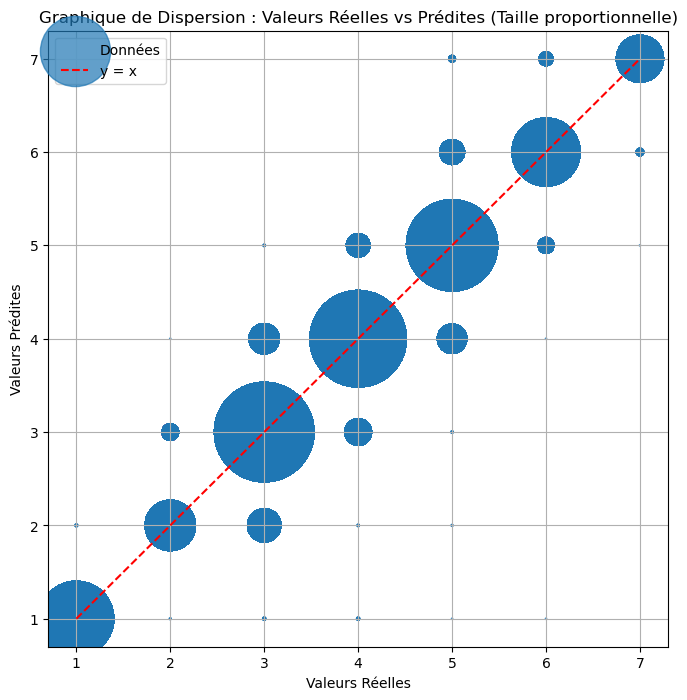

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

# Combiner y_test et y_pred dans un DataFrame pour calculer les fréquences
data = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
data['count'] = data.groupby(['y_test', 'y_pred'])['y_test'].transform('count')

# Taille des points proportionnelle à la fréquence
sizes = data['count']

# Tracer le graphique
plt.figure(figsize=(8, 8))
plt.scatter(data['y_test'], data['y_pred'], s=sizes, alpha=0.7, label='Données')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='y = x')
plt.title("Graphique de Dispersion : Valeurs Réelles vs Prédites (Taille proportionnelle)")
plt.xlabel("Valeurs Réelles")
plt.ylabel("Valeurs Prédites")
plt.grid(True)
plt.legend()
plt.show()


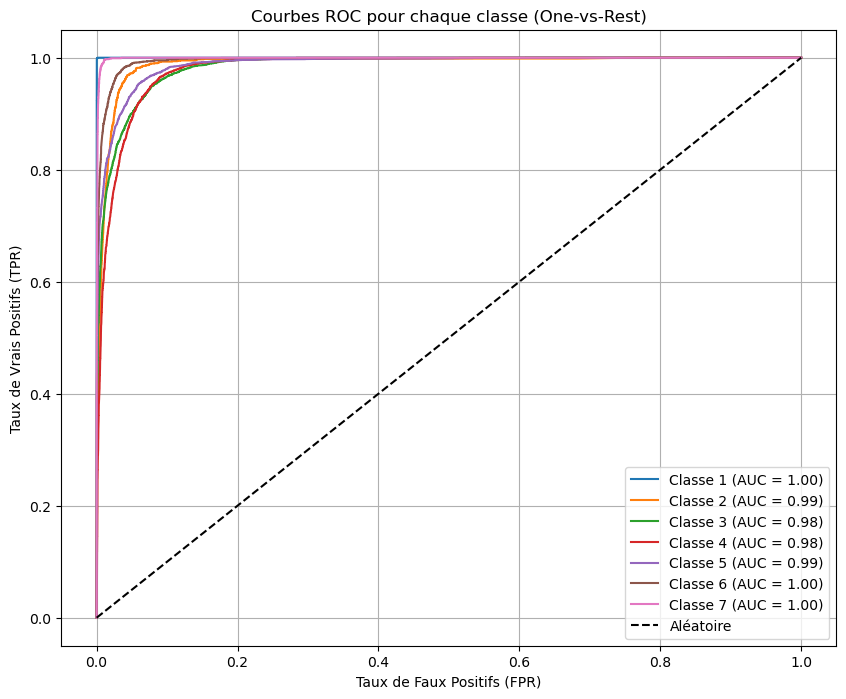

In [33]:
# courbe ROC pour nos 7 classes
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarisation des labels (OvR, One-vs-Rest)
y_test_binarized = label_binarize(y_test, classes=[1, 2, 3, 4, 5, 6, 7])

# Obtenir les probabilités prédites pour chaque classe
y_pred_proba = random_forest_model.predict_proba(X_test_scaled)

# Initialiser le graphique
plt.figure(figsize=(10, 8))

# Tracer la courbe ROC pour chaque classe
for i in range(7):  # Nombre de classes
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Classe {i+1} (AUC = {roc_auc:.2f})')

# Ligne diagonale (aléatoire)
plt.plot([0, 1], [0, 1], 'k--', label="Aléatoire")

# Personnalisation du graphique
plt.title("Courbes ROC pour chaque classe (One-vs-Rest)")
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.legend(loc='lower right')
plt.grid()
plt.show()


On ne ressent pas pour ce modèle le besoin d'égaliser les classes sur le dataset d'entraînement  

In [34]:
import joblib

# Chemin pour enregistrer le modèle
model_path = base_models + 'rf_cat.pkl'

# Enregistrer le modèle
joblib.dump(random_forest_model, model_path)

print(f"Modèle random_forest enregistré dans {model_path}")


Modèle random_forest enregistré dans ../models/rf_cat.pkl
